# NutriClass: Food Classification Using Nutritional Data

## Project Overview
In the era of increasing dietary awareness, the ability to classify food items based on nutritional attributes is invaluable. This project focuses on developing a machine learning model that categorizes food based on nutrients such as calories, proteins, carbohydrates, fats, sugar, and more. The model aims to accurately label food types while offering insights into what makes each category distinct.

## Problem Statement
The growing demand for healthier lifestyles has created a need for systems that can automatically classify foods using detailed nutritional information. This project builds a robust multi-class classification system using tabular nutritional data.

## Business Use Cases
- **Smart Dietary Applications** – Recommend balanced meals based on nutrient intake.
- **Health Monitoring Tools** – Assist nutritionists in structured diet planning.
- **Food Logging Systems** – Automatically classify user food entries.
- **Educational Platforms** – Teach learners about nutrition categories.
- **Grocery/Meal Planning Apps** – Suggest alternatives within the same category.

Contents:
- Synthetic dataset generator (or CSV loader)
- EDA and visualizations
- Preprocessing (missing values, outliers, duplicates, scaling)
- Feature engineering (PCA)
- Train/test split
- Model training: LogisticRegression, DecisionTree, RandomForest, KNN, SVM, XGBoost, GradientBoosting
- Hyperparameter tuning (GridSearchCV / RandomizedCV for heavy models)
- Evaluation (accuracy, precision, recall, f1, confusion matrix)
- Model comparison table and plots
- Saved best model

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sklearn

#### Model & Preprocessing

In [3]:
# Model & Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support
)

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Optional: XGBoost, may require installation
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False


RANDOM_STATE = 42
sns.set(style='whitegrid')

#### Configuration

In [5]:
# --- Configuration -------------------------------------------------------
USE_SYNTHETIC = True # Set to False if you want to load a CSV instead
DATA_PATH = 'nutriclass_food_data.csv' # used when USE_SYNTHETIC=False
n_samples = 8000

#### Synthetic Food Nutrition Dataset Generator (with Categories, Nutrient Distributions, Noise & Missing Values)

In [6]:
# --- Synthetic dataset generator -----------------------------------------
def generate_synthetic_food_data(n_samples=5000, random_state=RANDOM_STATE):
    np.random.seed(random_state)

    # Define food categories
    categories = [
        'Beverage',     # low calories, sugar varies
        'Fruit',        # moderate calories, high sugar, fiber
        'Vegetable',    # low calories, low sugar, fiber
        'Grain',        # moderate to high calories, carbs
        'Protein',      # calories from protein and fat
        'Dessert'       # high calories, high sugar, fat
    ]

    n_classes = len(categories)

    # We'll create feature distributions for each category
    rows = []
    for _ in range(n_samples):
        cls_idx = np.random.choice(n_classes, p=[0.12, 0.18, 0.18, 0.2, 0.18, 0.14])
        cls = categories[cls_idx]

        # base ranges
        if cls == 'Beverage':
            calories = np.random.normal(80, 40)
            protein = np.random.normal(0.5, 0.8)
            carbs = np.random.normal(10, 8)
            fat = np.random.normal(0.2, 0.5)
            sugar = np.random.normal(8, 7)
            fiber = np.random.normal(0.2, 0.5)
        elif cls == 'Fruit':
            calories = np.random.normal(60, 30)
            protein = np.random.normal(0.7, 0.6)
            carbs = np.random.normal(15, 6)
            fat = np.random.normal(0.3, 0.4)
            sugar = np.random.normal(12, 5)
            fiber = np.random.normal(2.5, 1.6)
        elif cls == 'Vegetable':
            calories = np.random.normal(35, 20)
            protein = np.random.normal(1.5, 1.2)
            carbs = np.random.normal(7, 4)
            fat = np.random.normal(0.2, 0.3)
            sugar = np.random.normal(2.8, 2.0)
            fiber = np.random.normal(2.2, 1.2)
        elif cls == 'Grain':
            calories = np.random.normal(230, 60)
            protein = np.random.normal(6, 3)
            carbs = np.random.normal(40, 10)
            fat = np.random.normal(2.5, 1.5)
            sugar = np.random.normal(3, 2)
            fiber = np.random.normal(3.5, 2.2)
        elif cls == 'Protein':
            calories = np.random.normal(250, 80)
            protein = np.random.normal(25, 10)
            carbs = np.random.normal(5, 4)
            fat = np.random.normal(12, 6)
            sugar = np.random.normal(1, 1)
            fiber = np.random.normal(0.8, 0.6)
        elif cls == 'Dessert':
            calories = np.random.normal(380, 120)
            protein = np.random.normal(4, 2.5)
            carbs = np.random.normal(45, 15)
            fat = np.random.normal(18, 8)
            sugar = np.random.normal(30, 12)
            fiber = np.random.normal(1.8, 1.5)

        # keep values realistic and non-negative
        calories = max(0, calories)
        protein = max(0, protein)
        carbs = max(0, carbs)
        fat = max(0, fat)
        sugar = max(0, sugar)
        fiber = max(0, fiber)

        # Additional micro-nutrients for more features
        sodium = abs(np.random.normal(150, 110))  # mg
        cholesterol = max(0, np.random.normal(10 if cls != 'Protein' else 70, 40))

        rows.append({
            'calories': round(calories, 2),
            'protein_g': round(protein, 2),
            'carbs_g': round(carbs, 2),
            'fat_g': round(fat, 2),
            'sugar_g': round(sugar, 2),
            'fiber_g': round(fiber, 2),
            'sodium_mg': round(sodium, 1),
            'cholesterol_mg': round(cholesterol, 1),
            'category': cls
        })

    df = pd.DataFrame(rows)

    # Introduce some duplicates, missing values and noise for realism
    # duplicates
    duplicates = df.sample(frac=0.01, random_state=random_state)
    df = pd.concat([df, duplicates], ignore_index=True).sample(frac=1, random_state=random_state).reset_index(drop=True)

    # missing values
    for col in ['protein_g', 'fiber_g', 'sodium_mg']:
        idx = np.random.choice(df.index, size=int(0.01 * len(df)), replace=False)
        df.loc[idx, col] = np.nan

    return df

#### Load or generate data

In [7]:
# --- Load or generate data -----------------------------------------------
if USE_SYNTHETIC:
    df = generate_synthetic_food_data(n_samples)
    print(f"Synthetic dataset generated with {len(df)} rows and {df.shape[1]} columns")
else:
    assert os.path.exists(DATA_PATH), f"CSV not found at {DATA_PATH}"
    df = pd.read_csv(DATA_PATH)
    print(f"Loaded dataset from {DATA_PATH} with {len(df)} rows")

# Quick peek
print(df.head())

Synthetic dataset generated with 8080 rows and 9 columns
   calories  protein_g  carbs_g  fat_g  sugar_g  fiber_g  sodium_mg  \
0    556.52       2.04    50.75  10.04    39.80     1.21       62.3   
1     29.25       1.04    15.45   0.36     4.65     3.83       78.4   
2    454.87       7.73     0.00  19.75     1.78     1.73      292.9   
3     69.45       0.00     9.76   0.15     1.10     3.16      338.1   
4     59.37       1.71     9.80   0.00     4.77     3.91        9.8   

   cholesterol_mg   category  
0             0.0    Dessert  
1            60.0  Vegetable  
2             4.9    Dessert  
3            41.0  Vegetable  
4             0.0  Vegetable  


#### EDA


Class distribution:
category
Grain        1649
Vegetable    1494
Fruit        1428
Protein      1405
Dessert      1108
Beverage      996
Name: count, dtype: int64


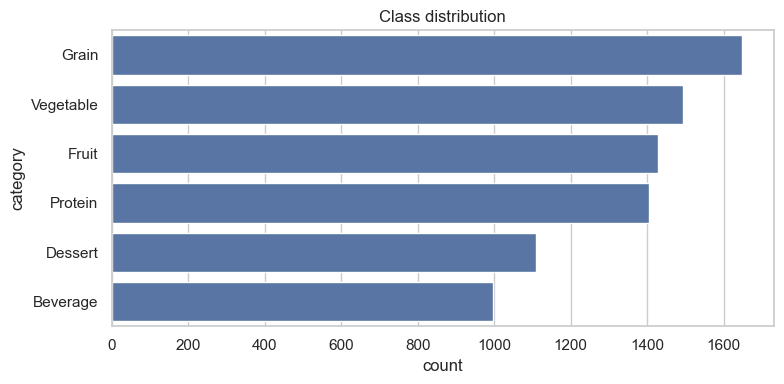


Statistical summary:
          calories    protein_g      carbs_g        fat_g      sugar_g  \
count  8080.000000  8000.000000  8080.000000  8080.000000  8080.000000   
mean    169.439876     6.565095    20.362691     5.257588     8.712670   
std     136.202600     9.634626    17.708310     7.698587    10.884228   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      52.490000     0.750000     6.557500     0.210000     1.640000   
50%     131.825000     2.330000    13.350000     0.920000     4.090000   
75%     262.465000     7.310000    33.780000     8.222500    12.240000   
max     775.510000    56.390000    92.750000    45.920000    67.590000   

           fiber_g    sodium_mg  cholesterol_mg  
count  8000.000000  8000.000000     8080.000000  
mean      2.040141   160.744350       29.773527  
std       1.741608    97.686031       34.035403  
min       0.000000     0.000000        0.000000  
25%       0.620000    84.000000        0.000000  
50%       1

In [8]:
# --- EDA -----------------------------------------------------------------
print('\nClass distribution:')
print(df['category'].value_counts())

plt.figure(figsize=(8,4))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('Class distribution')
plt.tight_layout()
plt.show()

# Statistical summary
print('\nStatistical summary:')
print(df.describe())

#### Pairplot for a smaller sample

<Figure size 1000x800 with 0 Axes>

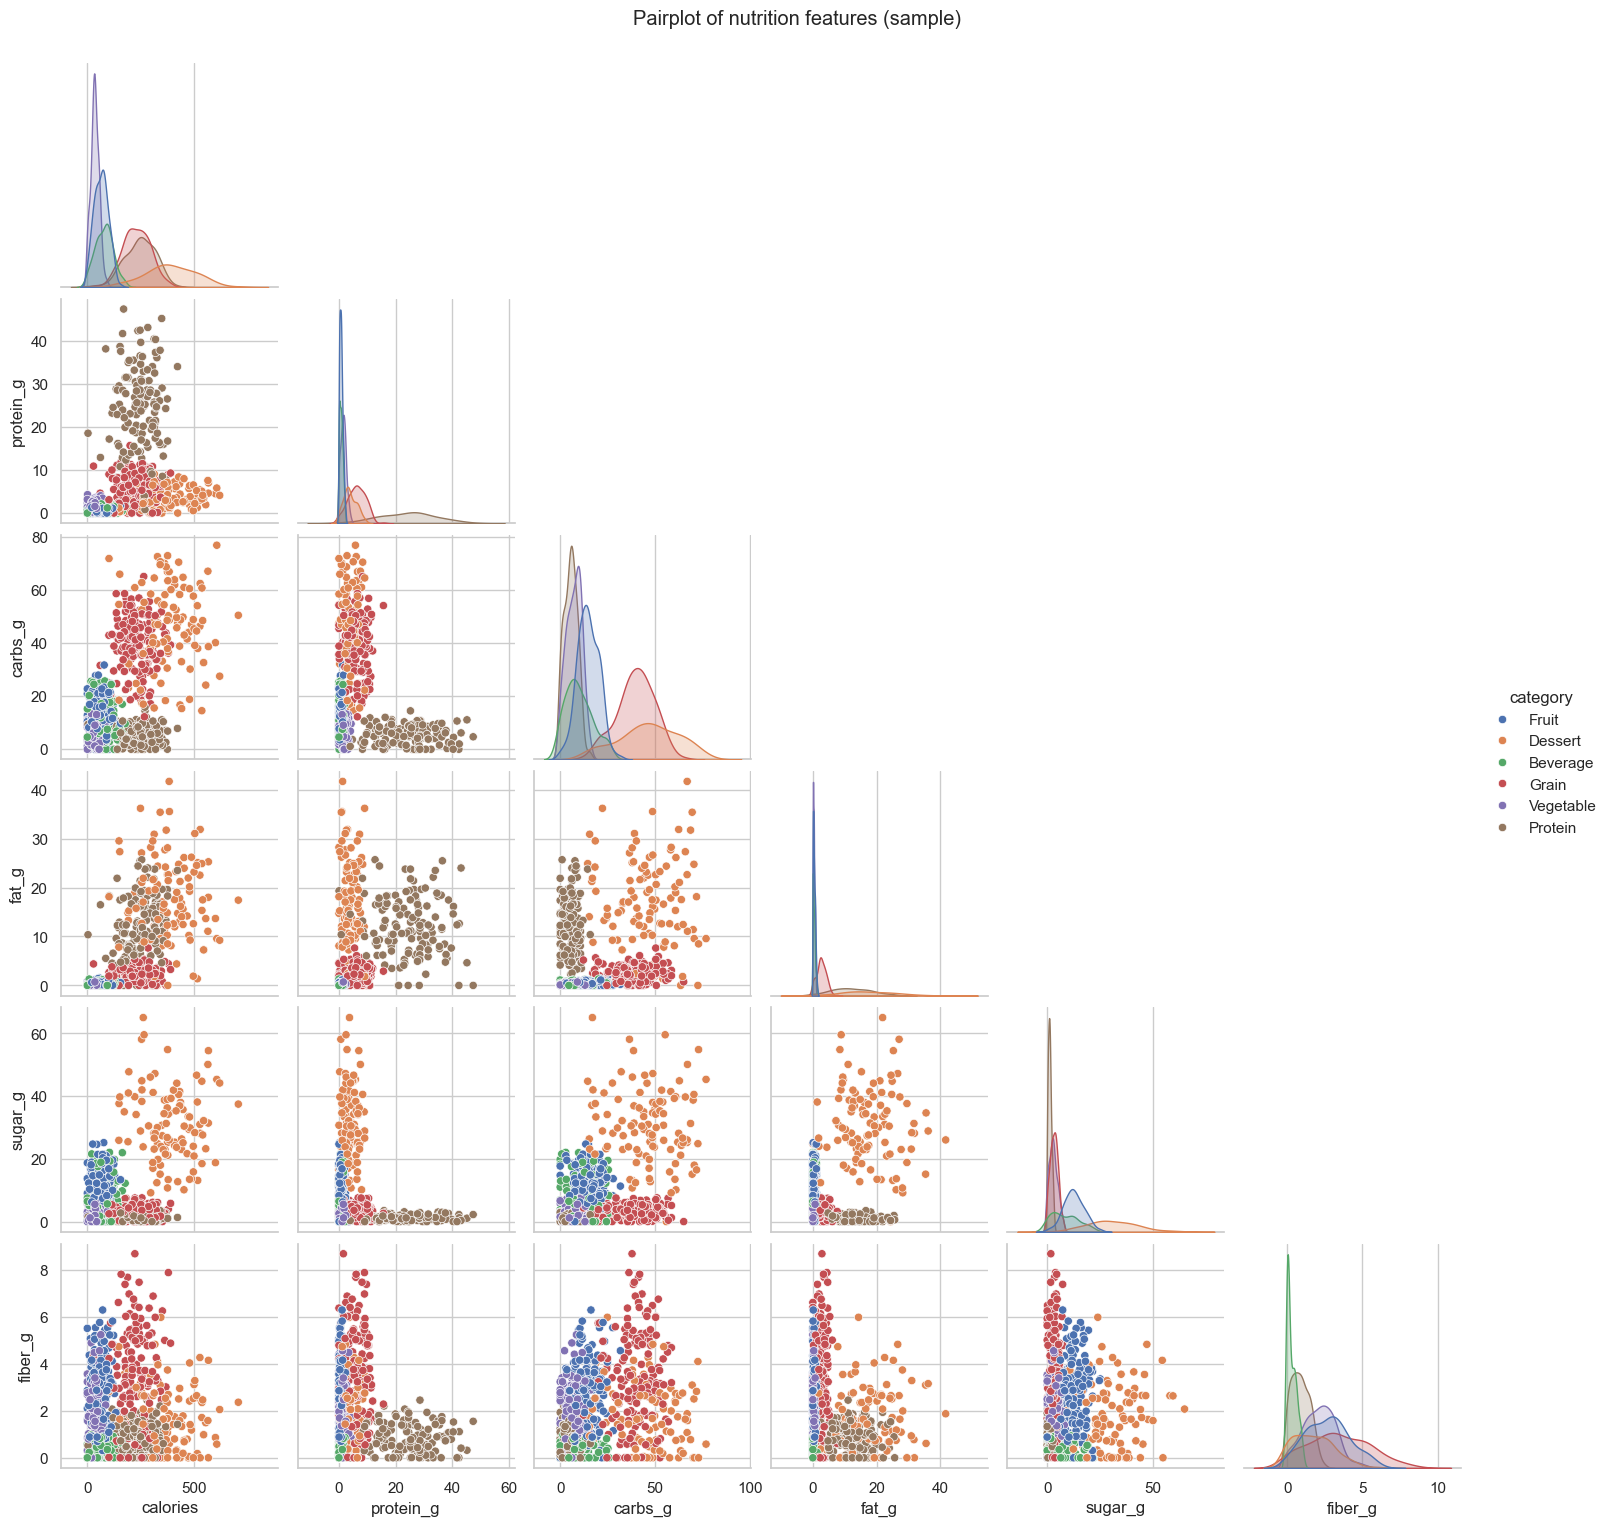

In [9]:
# Pairplot for a smaller sample (slow for many rows)
sample = df.sample(frac=0.1, random_state=RANDOM_STATE)
plt.figure(figsize=(10,8))
try:
    sns.pairplot(sample[['calories','protein_g','carbs_g','fat_g','sugar_g','fiber_g','category']], hue='category', corner=True)
    plt.suptitle('Pairplot of nutrition features (sample)', y=1.02)
except Exception as e:
    print('Pairplot skipped (might be slow):', e)

#### Correlation heatmap

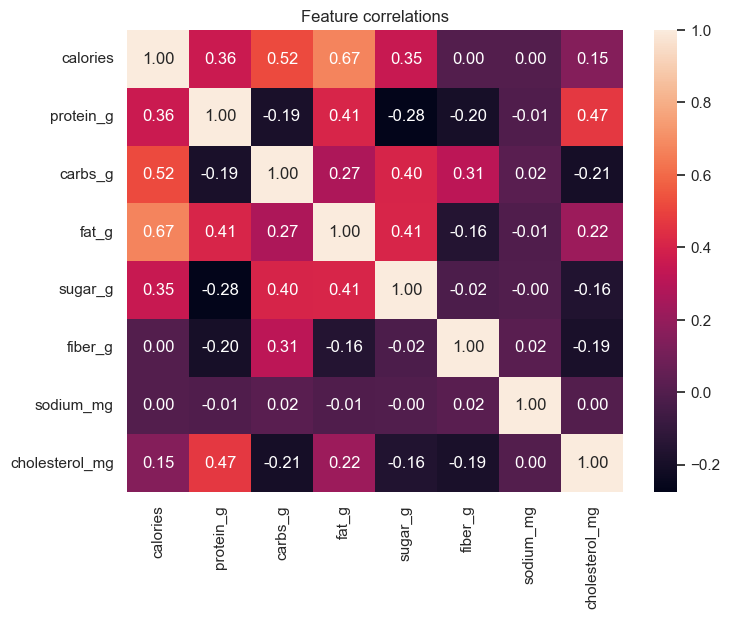

In [10]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt='.2f')
plt.title('Feature correlations')
plt.show()

#### Data cleaning & preprocessing

##### 1. Remove duplicates

In [ ]:
# --- Data cleaning & preprocessing --------------------------------------

before = len(df)
df = df.drop_duplicates().reset_index(drop=True)
after = len(df)
print(f"Dropped {before-after} duplicate rows")

Dropped 76 duplicate rows


##### 2. Missing values

In [12]:
# 2. Missing values
print('\nMissing values before:')
print(df.isna().sum())


Missing values before:
calories           0
protein_g         80
carbs_g            0
fat_g              0
sugar_g            0
fiber_g           80
sodium_mg         80
cholesterol_mg     0
category           0
dtype: int64


##### Impute numeric columns with median

In [13]:
# Simple strategy: impute numeric columns with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    med = df[col].median()
    df[col] = df[col].fillna(med)

print('\nMissing values after:')
print(df.isna().sum())


Missing values after:
calories          0
protein_g         0
carbs_g           0
fat_g             0
sugar_g           0
fiber_g           0
sodium_mg         0
cholesterol_mg    0
category          0
dtype: int64


##### 3. Outlier handling

In [14]:
# 3. Outlier handling — IQR capping for numeric features
def iqr_cap(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return series.clip(lower, upper)

for col in num_cols:
    if col != 'cholesterol_mg':
        df[col] = iqr_cap(df[col])

##### 4. Feature and label separation

In [15]:
# 4. Feature and label separation
X = df.drop(columns=['category'])
y = df['category']

# Encode label
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_
print('\nEncoded classes:', class_names)


Encoded classes: ['Beverage' 'Dessert' 'Fruit' 'Grain' 'Protein' 'Vegetable']


##### 5. Scaling

In [16]:
# 5. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### PCA 


PCA explained variance ratio: [0.30456391 0.24379809 0.13497376 0.12442559 0.08023563 0.05844044]


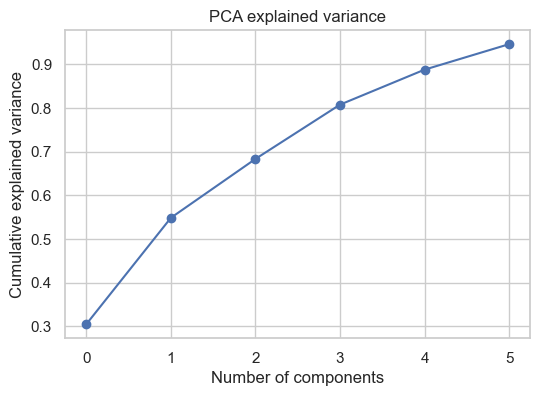

In [17]:
# Optional PCA (to inspect explained variance)
pca = PCA(n_components=min(6, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)
print('\nPCA explained variance ratio:', pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA explained variance')
plt.grid(True)
plt.show()

#### Train/test split

In [18]:
# --- Train/test split ---------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.2, stratify=y_enc, random_state=RANDOM_STATE)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 6403, Test size: 1601


#### Model training and evaluation helpers

In [19]:
# --- Model training and evaluation helpers -------------------------------
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_STATE)
}

if XGBOOST_AVAILABLE:
    models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE)

results = []

for name, model in models.items():
    print(f"\nTraining and cross-validating: {name}")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    results.append({'model': name, 'cv_mean_acc': np.mean(cv_scores), 'test_acc': acc, 'precision': prec, 'recall': rec, 'f1': f1})
    print(f"{name} CV acc: {np.mean(cv_scores):.4f}, Test acc: {acc:.4f}, F1: {f1:.4f}")

results_df = pd.DataFrame(results).sort_values('test_acc', ascending=False)
print('\nModel comparison:')
print(results_df)


Training and cross-validating: LogisticRegression
LogisticRegression CV acc: 0.9325, Test acc: 0.9332, F1: 0.9328

Training and cross-validating: DecisionTree
DecisionTree CV acc: 0.9139, Test acc: 0.9038, F1: 0.9034

Training and cross-validating: RandomForest
RandomForest CV acc: 0.9442, Test acc: 0.9425, F1: 0.9423

Training and cross-validating: KNN
KNN CV acc: 0.9221, Test acc: 0.9169, F1: 0.9164

Training and cross-validating: SVM
SVM CV acc: 0.9382, Test acc: 0.9313, F1: 0.9313

Training and cross-validating: GradientBoosting
GradientBoosting CV acc: 0.9408, Test acc: 0.9457, F1: 0.9453

Model comparison:
                model  cv_mean_acc  test_acc  precision    recall        f1
5    GradientBoosting     0.940809  0.945659   0.945296  0.945659  0.945291
2        RandomForest     0.944246  0.942536   0.942752  0.942536  0.942344
0  LogisticRegression     0.932533  0.933167   0.933199  0.933167  0.932757
4                 SVM     0.938156  0.931293   0.932919  0.931293  0.931252

#### Plot comparison

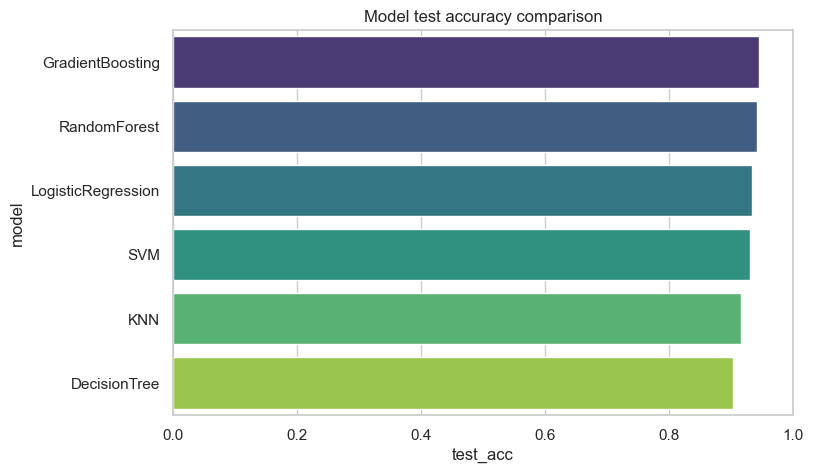

In [20]:
# Plot comparison
plt.figure(figsize=(8,5))
sns.barplot(x='test_acc', y='model', data=results_df, palette='viridis')
plt.xlim(0,1)
plt.title('Model test accuracy comparison')
plt.show()

#### Detailed evaluation for best model

In [21]:
# --- Detailed evaluation for best model ---------------------------------
best_model_name = results_df.iloc[0]['model']
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")


Best model: GradientBoosting


#### Predictions & classification report

In [22]:
# Predictions & classification report
y_pred_best = best_model.predict(X_test)
print('\nClassification report:')
print(classification_report(y_test, y_pred_best, target_names=class_names))


Classification report:
              precision    recall  f1-score   support

    Beverage       0.86      0.83      0.84       198
     Dessert       1.00      0.99      0.99       219
       Fruit       0.90      0.87      0.88       284
       Grain       0.99      1.00      0.99       326
     Protein       1.00      1.00      1.00       277
   Vegetable       0.91      0.96      0.94       297

    accuracy                           0.95      1601
   macro avg       0.94      0.94      0.94      1601
weighted avg       0.95      0.95      0.95      1601



#### Confusion matrix

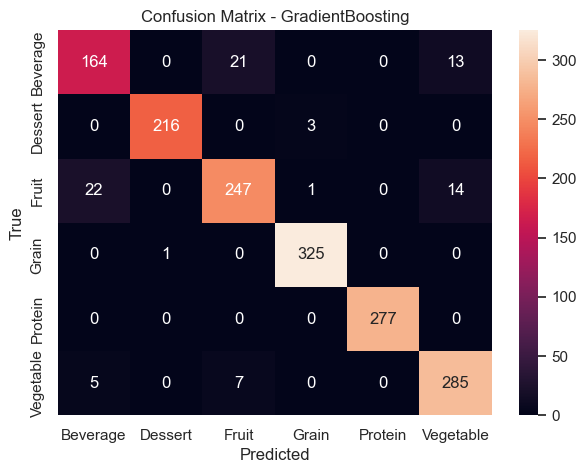

In [23]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

#### Feature importance 


Feature importances:
sugar_g           0.335448
protein_g         0.246307
calories          0.154675
carbs_g           0.143059
fiber_g           0.071339
fat_g             0.044985
cholesterol_mg    0.002708
sodium_mg         0.001477
dtype: float64


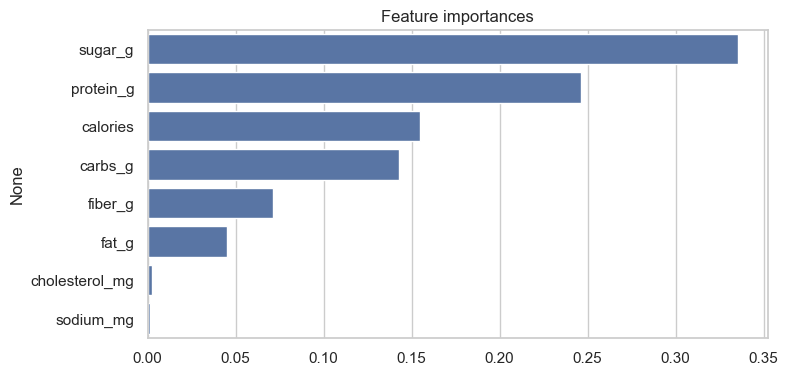

In [24]:
# Feature importance (for tree-based models)
if best_model_name in ['RandomForest', 'DecisionTree', 'GradientBoosting', 'XGBoost']:
    try:
        importances = best_model.feature_importances_
        feat_names = X.columns if hasattr(X, 'columns') else [f'feat_{i}' for i in range(X.shape[1])]
        fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)
        print('\nFeature importances:')
        print(fi)
        plt.figure(figsize=(8,4))
        sns.barplot(x=fi.values, y=fi.index)
        plt.title('Feature importances')
        plt.show()
    except Exception as e:
        print('Could not compute feature importances:', e)

#### Save model & artifacts

In [25]:
# --- Save model & artifacts ---------------------------------------------
import joblib
os.makedirs('artifacts', exist_ok=True)
joblib.dump(best_model, 'artifacts/nutriclass_best_model.joblib')
joblib.dump(scaler, 'artifacts/nutriclass_scaler.joblib')
joblib.dump(le, 'artifacts/nutriclass_labelencoder.joblib')
print('\nSaved best model and preprocessing artifacts to artifacts/')


Saved best model and preprocessing artifacts to artifacts/


#### Report generation

In [26]:
# --- Report generation (basic) ------------------------------------------
summary = {
    'dataset_rows': len(df),
    'features': X.shape[1],
    'classes': list(class_names),
    'best_model': best_model_name,
    'test_accuracy': float(results_df.iloc[0]['test_acc'])
}

print('\nProject summary:')
for k, v in summary.items():
    print(f"{k}: {v}")


Project summary:
dataset_rows: 8004
features: 8
classes: ['Beverage', 'Dessert', 'Fruit', 'Grain', 'Protein', 'Vegetable']
best_model: GradientBoosting
test_accuracy: 0.9456589631480324


#### Suggestions

In [27]:
# --- Next steps & suggestions -------------------------------------------
print('\nSuggested next steps:')
print('- Try more advanced feature engineering (ratios like protein/calorie, fat/calorie)')
print('- Use class-aware sampling or class weights if classes are imbalanced')
print('- Try stacking / blending models for better performance')
print('- Collect real-world labeled data to replace synthetic generator')
print('- Deploy model as REST API using FastAPI or Flask for inference in apps')

# End of notebook


Suggested next steps:
- Try more advanced feature engineering (ratios like protein/calorie, fat/calorie)
- Use class-aware sampling or class weights if classes are imbalanced
- Try stacking / blending models for better performance
- Collect real-world labeled data to replace synthetic generator
- Deploy model as REST API using FastAPI or Flask for inference in apps
